###  Removal of Basis-Set Artifacts in Kohn−Sham Potentials Recovered from Electron Densities 
J. Chem. Theory Comput. 2013, 9, 3959−3964

#### Introduction:

Gaiduk, Ryabinkin and Staroverov investigated that, one should be able to obtain the exchange-correlation potential $v_{xc}(r)$ from a set of canonical orbitals. This could be done by manipulating the Kohn-Sham equations as:


$$
[-\frac{1}{2} \nabla^2 + v_{eff}(r)] \phi_i(r) = \varepsilon_i \phi_i(r)
$$

Where $$veff = v(r) + v_{H}(r) + v_{xc}(r)$$ 

Obtain $v_{xc}(r)$ from:

$$v_{xc}(r) = \frac{1}{n(r)} \sum_i^N [\phi_i^{*} (r) \nabla^2 \phi_i(r) + \varepsilon_i | \phi_i(r)|^2] $$


Such procedure introduces oscillations and asymptotic divergences that have origin in small oscillations in the Kohn-Sham orbitals that are amplified by the Laplacian. 

We can perform such an inversion in $\textit{n2v}$. Let us see how:

In [1]:
#Import modules
#import sys
#sys.path.insert(1, "/Users/aosborne3/Desktop/research_tutorials/n2v")
import n2v
import psi4
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 

In [2]:
#Set options within Psi4.
#Saving the jk object prevents n2v to build it again. 
psi4.set_options({"save_jk" : True})

#n2v is driven by psi4's reference option. Make sure you set it accordingly. 
psi4.set_options({"reference" : "rhf"})

#Set memory and avoid inheriting options from a different calculation. 
psi4.set_memory(int(2.50e9))
psi4.core.clean()

In [3]:
# Let us focus on the Neon atom.

# Define Psi4 geometries. Symmetries need to be set to C1!
Ne = psi4.geometry(
"""
0 1
Ne 0.0 0.0 0.0
noreorient
nocom
units bohr
symmetry c1
""")

# Perform a DFT calculation.
e, wfn = psi4.energy("svwn/cc-pvtz", return_wfn=True, molecule=Ne)


# Define inverter objects for each molecule. Simply use the wnf object from psi4 as an argument.
ine = n2v.Inverter.from_wfn(wfn)

# Define a grid to visualize all of the generated potentials.
# Since we are using radially symmetric atoms, we focus on the space from the origin all the way to 10 a.u.
npoints=10002
x = np.linspace(0,10,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1).T

RuntimeError: 
Fatal Error: PSIOManager cannot get a mirror file handle

Error occurred in file: /Users/runner/miniforge3/conda-bld/psi4_1709839991841/work/psi4/src/psi4/libpsio/filemanager.cc on line: 175
The most recent 5 function calls were:



In [4]:
#let us invert the kohn-sham equations:
vxc_inverted = ine.invert('direct', grid=grid, correction=False)

Text(0.5, 0.98, 'Neon Atom Vxc')

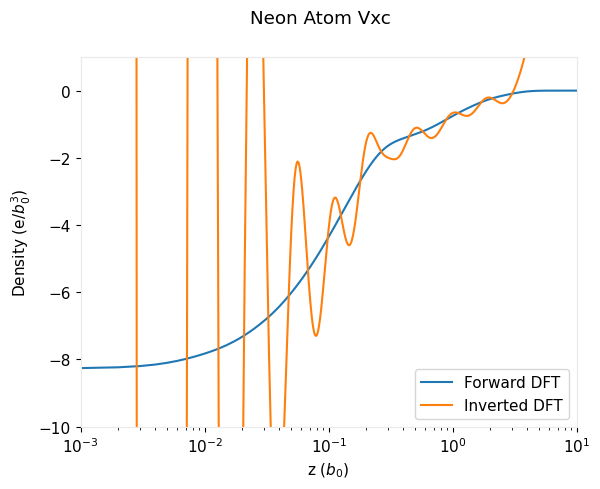

In [5]:
#Compare the performance of direct and reversed calculation of vxc. 
vxc0 = ine.eng.grid.vxc(Da=wfn.Da().np, Db=wfn.Db().np, grid=grid)

#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=100)


#---------------> Data
ax.plot(x, vxc0, label="Forward DFT")
ax.plot(x, vxc_inverted, label="Inverted DFT")

#---------------> Formatting
ax.set_xlim(0.001,10)
ax.set_ylim(-10,1)
ax.set_ylabel('Density (e/$b_0^3$)')
ax.set_xscale('log')
ax.set_xlabel('z ($b_0$)')
ax.legend()

fig.suptitle("Neon Atom Vxc")


We can correct this behavior by isolating the oscillations--that are basis-set specific-- from an LDA exchange only calculation, and then removing them from subsequent calculations.  
Currently, *n2v* only supports local functionals and thus we can only compare forward and reversed LDA. Nevertheless the procedure works for other functionals as well. 

In [6]:
vxc_inverted_corr = ine.invert('direct', grid=grid, correction=True)

Text(0.5, 0.98, 'Neon Atom Vxc')

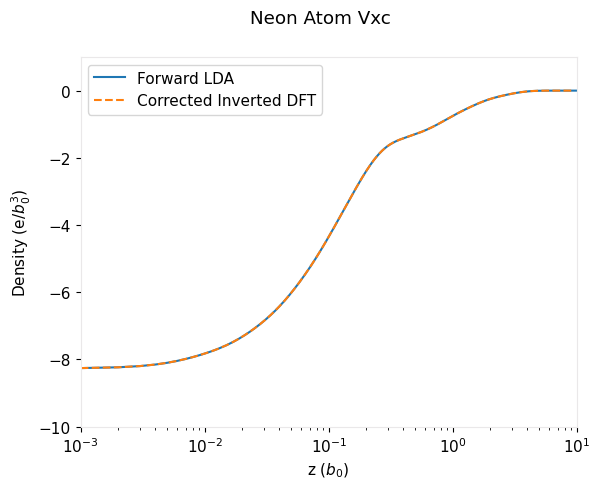

In [7]:
vxc0 = ine.eng.grid.vxc(Da=wfn.Da().np, Db=wfn.Db().np, func_id=1, grid=grid)

#---------------> Plot
fig, ax = plt.subplots(1,1, dpi=100)


#---------------> Data
ax.plot(x, vxc0, label="Forward LDA")
ax.plot(x, vxc_inverted_corr, '--',label="Corrected Inverted DFT")

#---------------> Formatting
ax.set_xlim(0.001,10)
ax.set_ylim(-10,1)
ax.set_ylabel('Density (e/$b_0^3$)')
ax.set_xscale('log')
ax.set_xlabel('z ($b_0$)')
ax.legend()

fig.suptitle("Neon Atom Vxc")


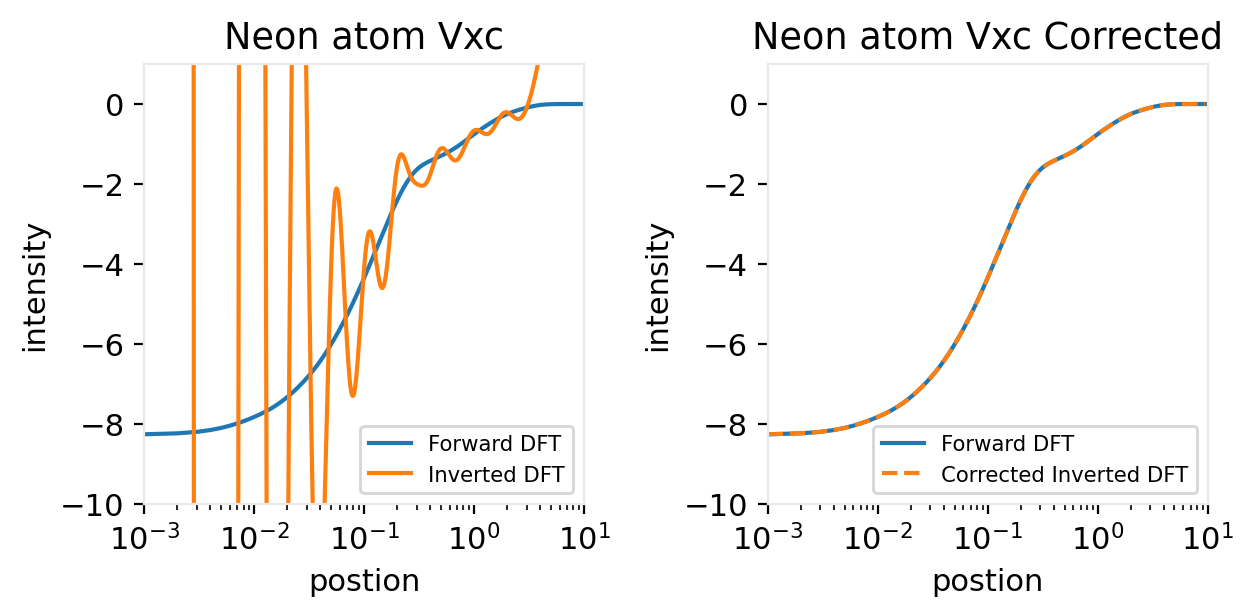

In [8]:
#---------------> Plot
fig, ax = plt.subplots(1, 2, dpi=200)
#---------------> Data
ax[0].plot(x, vxc0, label="Forward DFT")
ax[0].plot(x, vxc_inverted, label="Inverted DFT")
ax[1].plot(x, vxc0, label="Forward DFT")
ax[1].plot(x, vxc_inverted_corr, '--',label="Corrected Inverted DFT")
#---------------> Formatting
#-------> Labels
ax[0].set_xlabel('postion')
ax[0].set_ylabel('intensity')
ax[0].legend(loc='best', fontsize='x-small')
ax[1].set_xlabel('postion')
ax[1].set_ylabel('intensity')
ax[1].legend(loc='best', fontsize='x-small')
#-------> Titles
ax[0].title.set_text('Neon atom Vxc')
ax[1].title.set_text('Neon atom Vxc Corrected')

#-------> Sizing
ax[0].set_xlim(0.001,10)
ax[0].set_ylim(-10, 1)
ax[1].set_xlim(0.001,10)
ax[1].set_ylim(-10,1)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
fig.tight_layout()
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.00
#fig.suptitle("Neon atom Vxc")